In [48]:
import numpy as np
import math
from numpy.linalg import multi_dot
import scipy.stats as st
import json

In [49]:
# # first, define our problem size
# n = 10
# alpha = np.random.random((n, 1))
# k = np.random.random((n, n))
# sigma = np.array([[k[i][i]] for i in range(n)])

# # TODO: figure out how to stitch together the r_opt values with the actual stock names
# stock_names = [f'stock_{i}' for i in range(n)]

# # TODO? figure out how to generate the confidence intervals of how much money you expect to make from this

# # TODO, pick one stock to be the baseline (stock_0). Figure out some way of comparing
# # stock_0's expected performance compared to our optimal solver

# # Katrina's draft:

# max_num_stocks = 5

# # DRAFT END

# # goal, generate some vector r such that:
# # sum(r) = 1.0
# # r represents our optimal investment portfolio

In [61]:

max_num_stocks = 10
investment_window_days = 30

In [62]:
# load the data
json_data = json.loads(open('tmp.txt', 'r').read())
covariance_matrix = np.array(json_data['covariance_matrix'])
mean_vector = np.array(json_data['mean_vector'])
ticker_to_index = json_data['ticker_to_index']

index_to_ticker = {v: k for k, v in ticker_to_index.items()}

In [63]:
# alpha is the mean
# sigma is the variance along the diagonal
# k is the covariance matrix

alpha = mean_vector * investment_window_days
sigma = np.diag(covariance_matrix) * investment_window_days
k = covariance_matrix * investment_window_days

In [64]:
# element-wise math

# square every term in alpha
alpha_element_squared = alpha * alpha
sigma_element_squared = sigma * sigma

# the 3.9 formula from
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
alpha / (alpha_element_squared + sigma_element_squared)


array([  15.19226916,   15.38665619,   29.93916157,   27.54297103,
         44.57373755,   32.62353478,   27.16140236,   42.23063759,
         23.25608044,   26.0930985 ,   19.8289102 ,   33.59554554,
         22.09074338,   34.6302797 ,   75.62027947,   84.56824396,
         26.97197923,   21.4613569 ,   13.36432573,   23.87075154,
         24.16057394,   51.02199119,    9.0407981 ,   10.07359549,
         21.28933749,   25.61563762,   26.85625592,    8.85008989,
         66.9452151 ,   21.20214134,   32.44864563,  -53.21662807,
         15.50212191,   61.71099861,   50.93422475,   14.72737346,
         37.54442325,   23.88203182,   22.35565543,   28.17802676,
         10.07122168,  -55.01015937,   24.91962671,   14.07893223,
         41.74972347,  -74.13332174,  -33.15884494,   21.25345023,
         25.09520726,   15.03196256,   31.33502901,   18.98711824,
         33.22086613,   23.47150081,   18.08731914,    7.17645021,
          8.22349555,   19.12587102,   56.79012466,   18.57263

In [65]:
# invert matrices
k_inv = np.linalg.inv(k)

# formula 3.10 from 
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
r_opt = np.dot(k_inv, alpha)


In [66]:
# hints that I'm not sure how they all go together

# from formula 3.11
# you know that if \lambda >= \alpha_i, then we can ignore that term

# Maybe if you sort all fo the \alpha_i terms, you can see if a solution for lambda exists where all of the smaller
# values are ignored, and all of the larger values are effected by \lambda

# if you look at each term in the sum of 3.12, they are piecewise linear wrt. \lambda


In [67]:
# idea one to solve this: use line search
# main idea: function 3.12 is monotically decreasing
# so if we pick upper/lower bounds of lambda, we can just do a line search and call it a day
# monotonically decreasing means the derivative of the function wrt lambda is <= 0 across all values of lambda

# upper bound, we know that if lambda causes all of the terms to be zero, we went too far.
# i.e., alpha_i - upper_bound_lambda <= 0 \forall i
upper_bound_lambda = np.max(alpha)

# lower bound, we know that each term in the sum is >= 0 and <= the total sum term.
# so just find the lower bound of each term and take the maximum out of all of these terms
# for each term, lambda = alpha_i - alpha_i^2 - sigma_i^2
# I know this because I can do high-school algebra in my head... work it out on paper if you can't
lower_bound_lambda = np.min(alpha - (alpha_element_squared + sigma_element_squared))
# # # TODO, think about cases where there are zero values in r_opt
# # r_opt_top_stocks = r_opt[np.argsort(-r_opt)[:max_num_stocks]]
# # r_opt_top_stocks /= np.sum(r_opt_top_stocks)

# r_opt_top_stocks = [r_opt_with_names[best_stock_index][0] for best_stock_index in best_stock_indices]
# r_opt_top_stocks = np.array(r_opt_top_stocks_with_names) / np.sum(r_opt_top_stocks_with_names)
# r_opt_top_stocks

# r_opt_top_stocks_with_names = [r_opt_with_names[best_stock_index] for best_stock_index in best_stock_indices]
# r_opt_top_stocks_with_namespha - alpha_element_squared - sigma_element_squared)

print(lower_bound_lambda, upper_bound_lambda)

# now line search/binary search... first we need to evaluate the value of the 3.12 summation expression
def eval_expression(lambda_value):
    # subtract one so I can get something like \sum - 1 = 0 to solve.
    fractional_terms = (alpha - lambda_value) / (alpha_element_squared + sigma_element_squared)
    # heavyside function
    fractional_terms = np.maximum(fractional_terms, 0)
    return np.sum(fractional_terms) - 1

# sanity check, the correct value (0) is between the upper bound and lower bound
eval_expression(lower_bound_lambda), eval_expression(upper_bound_lambda)

# there's a tolerance term usually, more on that later
tolerance = 1e-9

# initialize our loop with our initial guess
lower_lambda = lower_bound_lambda
upper_lambda = upper_bound_lambda
middle_lambda = (lower_bound_lambda + upper_bound_lambda) / 2

iterations = 0
while np.abs(eval_expression(middle_lambda)) > tolerance:
    middle_value = eval_expression(middle_lambda)
    if middle_value > 0:
        lower_lambda = middle_lambda
    else:
        upper_lambda = middle_lambda
    middle_lambda = (lower_lambda + upper_lambda) / 2

    iterations += 1
    print(f'iteration: {iterations}, {middle_lambda}, {eval_expression(middle_lambda)}')


-0.03760584567752629 0.2160697979492408
iteration: 1, 0.15265088704254903, 0.23209232860929596
iteration: 2, 0.18436034249589492, -0.383953835695352
iteration: 3, 0.168505614769222, -0.07593075354302836
iteration: 4, 0.1605782509058855, 0.07808078753313374
iteration: 5, 0.16454193283755375, 0.0010750169950526356
iteration: 6, 0.16652377380338787, -0.03742786827398781
iteration: 7, 0.1655328533204708, -0.01817642563946731
iteration: 8, 0.16503739307901227, -0.008550704322207281
iteration: 9, 0.164789662958283, -0.0037378436635773227
iteration: 10, 0.16466579789791838, -0.0013314133342623435
iteration: 11, 0.16460386536773608, -0.00012819816960507602
iteration: 12, 0.16457289910264492, 0.0004734094127238908
iteration: 13, 0.1645883822351905, 0.00017260562155918535
iteration: 14, 0.1645961238014633, 2.2203725976943645e-05
iteration: 15, 0.16459999458459967, -5.299722181373312e-05
iteration: 16, 0.1645980591930315, -1.5396747918616782e-05
iteration: 17, 0.16459709149724738, 3.4034890294964

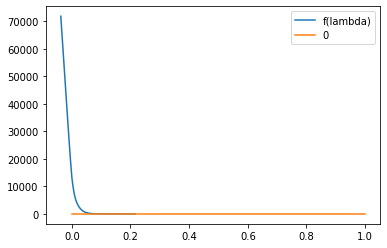

In [68]:
import matplotlib.pyplot as plt

x = np.linspace(lower_bound_lambda, upper_bound_lambda, 101)
plt.plot(x, [eval_expression(el) for el in x], label='f(lambda)')
plt.plot([0, 1], [0, 0], label='0')
plt.legend()

plt.show()


In [69]:
# get the optimal investment portfolio
r_opt = np.maximum(0, (alpha - middle_lambda) / (alpha_element_squared + sigma_element_squared))
r_opt = r_opt.flatten()

# r_opt_with_names = list(zip(r_opt, stock_names))
best_stock_indices = np.argsort(-r_opt)[:max_num_stocks]
best_stock_prices = r_opt[best_stock_indices]
best_stock_prices /= np.sum(best_stock_prices)

r_opt_top_stocks_with_names = []
for best_stock_price, best_stock_index in zip(best_stock_prices, best_stock_indices):
    r_opt_top_stocks_with_names.append([best_stock_price, index_to_ticker[best_stock_index]])
r_opt_top_stocks_with_names


[[1.0, 'MRNA'],
 [0.0, 'NXPI'],
 [0.0, 'NWSA'],
 [0.0, 'NWS'],
 [0.0, 'NWL'],
 [0.0, 'NVR'],
 [0.0, 'NVDA'],
 [0.0, 'NUE'],
 [0.0, 'NTRS'],
 [0.0, 'NTAP']]

In [70]:
expected_val = np.dot(r_opt, alpha)


In [71]:
# brief lecture on probabilities (mean/variance)
# E[X]=mean(X), Var[X]=Variance(X)
# let a be a constant
# Var[X] = E[X^2] - E[X]^2
# aE[X] = E[aX]
# a^2Var[X] = Var[(aX)]
# Let v be some vector, K be the covariance matrix
# Var(Kv) = v^t K v

# we now have r_opt, find the mean and variance of investing in r_opt
# alpha, sigma

# Amber and Katrina's draft:

expected_val = np.dot(r_opt, alpha)

print("Mean/expected total return: ", expected_val)

# TODO: find the variance with weighted variables formula that includes r_opt values (Attempted/done 9/3/21)

# http://www.math.kent.edu/~reichel/courses/monte.carlo/alt4.7d.pdf

# (r_opt^T * covariance_matrix * r_opt)

# T is transpose. Matrix product operation (dot product)

# variance = sum((expected_return_array[i] - expected_val)**2 for i in range(len(expected_return_array) - 1)) / len(expected_return_array)

variance = multi_dot([r_opt.T, covariance_matrix, r_opt])

standard_dev = np.sqrt(variance)

print("Variance: ", variance)
print("Standard dev: ", standard_dev, "\n")

# Calculating confidence intervals:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
for confidence_level in [0.99, 0.95, 0.85]:
    error = abs(st.norm.ppf((1-confidence_level)/2)) * standard_dev
    print(f"{confidence_level * 100}% confidence interval: {expected_val}", u"\u00B1", error)


Mean/expected total return:  0.21606979796587683
Variance:  0.002306120764267291
Standard dev:  0.048022086213192476 

99.0% confidence interval: 0.21606979796587683 ± 0.12369669688549283
95.0% confidence interval: 0.21606979796587683 ± 0.09412155944033472
85.0% confidence interval: 0.21606979796587683 ± 0.0691293044040103


In [72]:
np.exp(0.11676983430967593)

1.1238607257395243

In [73]:
np.argsort(-alpha)[:max_num_stocks]

array([313, 147,  56, 192, 314,  27, 338,  22, 247, 201])

In [74]:
[index_to_ticker[el] for el in np.argsort(-alpha)[:20]]

['MRNA',
 'DVN',
 'BBWI',
 'FTNT',
 'MRO',
 'AMAT',
 'NUE',
 'ALB',
 'IT',
 'GNRC',
 'ZBRA',
 'FANG',
 'IVZ',
 'SIVB',
 'TPR',
 'OXY',
 'PWR',
 'ENPH',
 'ALGN',
 'TECH']

In [75]:
[alpha[el] for el in np.argsort(-alpha)[:20]]

[0.2160697979492408,
 0.127621051682646,
 0.11597531123255246,
 0.11329661148852861,
 0.11235184384713272,
 0.10907188479426015,
 0.10495738497491627,
 0.10286353190089702,
 0.10180588587796904,
 0.10121347068361523,
 0.10118571697135063,
 0.09992848445488131,
 0.09948346611659643,
 0.09937703513052373,
 0.09685402924184369,
 0.09606808831549678,
 0.09506469352544446,
 0.09289806294668931,
 0.09139010014551054,
 0.08889924870170969]

In [76]:
np.exp(0.010663833857211109) * 365

368.91312674213805

In [77]:
indices = np.array([ticker_to_index[ticker] for ticker in ['ETSY']])
np.array([[covariance_matrix[i, j] for i in indices] for j in indices])
r_opt[indices]
index_variance = np.array([[covariance_matrix[i, j] for i in indices] for j in indices])
index_mean = r_opt[indices]


In [78]:
variance = multi_dot([index_mean.T, index_variance, index_mean])
variance

0.0

In [79]:
np.sqrt(variance)

0.0

In [80]:
index_variance

array([[0.00152977]])

In [81]:
index_mean

array([0.])

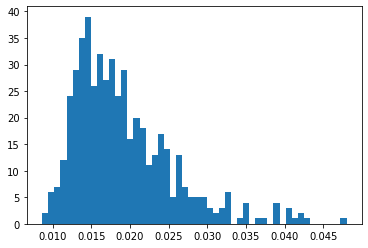

In [82]:
plt.hist(np.sqrt(np.diag(covariance_matrix)), bins=50)
plt.show()

In [25]:
np.sqrt(index_variance)

array([[0.0288529]])

### what do I want to do to clean up this code:
* combine everything into one notebook (should be a fairly easy script to run)
* put all of the important parameters that you might ever want to change (like investment length of time, or amount of time to look at historical data) at the top
* delete graphs that are unnecessary
* Write comments describing what the code does
* Small writeup on what we tried, why stuff worked/didn't work